In [8]:
import numpy as np
import pandas as pd

import os
import re
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=(8, 4))
plt.style.use('seaborn-v0_8-bright')

import cartopy.crs as ccrs

import GRACE_data_functions as grace_tools
import GNSS_data_functions as gnss_tools

# I. Chargement et traitement des données
## A. Données GNSS
### A.1 Provenance et description des données

- First, GNSS time series data is downloaded from the Nevada University website : http://geodesy.unr.edu/NGLStationPages/gpsnetmap/GPSNetMap.html.
- In the following cell, we define a function that processes a GNSS signal. The files are downloaded in the tenv3 format, they contain the dates, 3 components, variance and station coordinates.

### A.2 Traitement des données GNSS

- Dans un premier temps la tendance linéaire des séries temporelle est retirée. Un filtre passe-bas permet de retirer les variations brusques contenues dans les hautes fréquences, et donc l'élimination des outliers.

In [15]:
def load_GNSS_tenv_data(data_dir):

    gnss_df = None
    stations = {}

    list_files = os.listdir(data_dir)

    for file in list_files:
                
        if not(file[-5:] == "tenv3"): continue
        
        # Load GNSS data
        gnss_df_tmp = pd.read_fwf(os.path.join(data_dir,file), infer_nrows=10)

        # Extraction site, longitude de réference, latitude et longitude de la station
        site, lon_ref, lat, lon = gnss_df_tmp.iloc[0][["site","reflon","_latitude(deg)","_longitude(deg)"]]
        stations[site] = (lat,lon)

        # Somme des colonnes déplacements
        for col_sum, (col_int,col_dec) in zip(["east_orig","north_orig","up_orig"], [('_e0(m)', '__east(m)'), ('____n0(m)', '_north(m)'), ('u0(m)', '____up(m)')]):
            # gnss_df_tmp[col_sum] = gnss_df_tmp[col_int] + gnss_df_tmp[col_dec]
            gnss_df_tmp[col_sum] = gnss_df_tmp[col_dec]
            
        # Construction colonne datetime
        gnss_df_tmp["Date"] = decimal_year_to_date(gnss_df_tmp["yyyy.yyyy"])

        # Conserver uniquement colonnes intéressantes : 
        gnss_df_tmp = gnss_df_tmp[["site","Date","yyyy.yyyy","east_orig","north_orig","up_orig"]]

        # Remove linear trend
        for col1,col2 in zip(["east_orig","north_orig","up_orig"],["east_detrended","north_detrended","up_detrended"]):
            coeffs = np.polyfit(gnss_df_tmp["yyyy.yyyy"], gnss_df_tmp[col1], 1)
            fit_line = fit_line = np.poly1d(coeffs)
            gnss_df_tmp[col2] = gnss_df_tmp[col1] - fit_line(gnss_df_tmp["yyyy.yyyy"])
                
        # Remove outliers by applying low-pass filters then having a relative difference threshold
        
        cut_period = 1/6 # 2 months
        ts_abs_diff = 1.5e-2 # 1.5cm
        
        N_pts = len(gnss_df_tmp)

        # Comparaison entre la série temporelle filtrée et non filtrée. Élimine les résidus trop élevés.
        for col1,col2,col3 in zip(["east_detrended","north_detrended","up_detrended"],["east_dt_filtered","north_dt_filtered","up_dt_filtered"],["east_dt_filter_res","north_dt_filter_res","up_dt_filter_res"]):
            # Filtre
            gnss_df_tmp[col2] = butter_lowpass_filter(gnss_df_tmp["yyyy.yyyy"], gnss_df_tmp[col1], cut_period)
            # Calcul des résidus
            gnss_df_tmp[col3] = np.abs((gnss_df_tmp[col1] - gnss_df_tmp[col2]))
            # Élimine les points au dessus d'un seuil (ts_bas_diff)
            gnss_df_tmp = gnss_df_tmp[gnss_df_tmp[col3] <= ts_abs_diff]
            
        print(f"Station {site} : {N_pts - len(gnss_df_tmp)} outliers removed.")
                    
        # Redéfinit la série temporelle.
        gnss_df_tmp = gnss_df_tmp.rename(columns={"site":"Station"})
        if gnss_df is None : 
            gnss_df = gnss_df_tmp[["Station","Date",'up_orig', 'north_orig', 'east_orig','up_detrended', 'north_detrended', 'east_detrended','up_dt_filtered', 'north_dt_filtered', 'east_dt_filtered']]
        else : 
            gnss_df = pd.concat([gnss_df,gnss_df_tmp[["Station","Date",'up_orig', 'north_orig', 'east_orig','up_detrended', 'north_detrended', 'east_detrended','up_dt_filtered', 'north_dt_filtered', 'east_dt_filtered']]], ignore_index=True)

    gnss_df = gnss_df.set_index(["Station","Date"])
    
    return gnss_df,stations

### A.3 Lecture des données

- Les données sont dans le dossier GNSS_data et on utilise la fonction définit précédemment pour les traiter.
- En résumé du traitement des données, on montre le nombre d'outliers supprimés et les informations des stations utilsées.

In [9]:
gnss_data_dir = "../GNSS_data"
gnss_df,stations = gnss_tools.load_GNSS_tenv_data(gnss_data_dir)

print("\nStations chargées :")
for station,(lat,lon) in stations.items():
    print(f"{station} lat={lat:.1f}° lon={lat:.1f}°")

Station AMCO : 230 outliers removed.
Station MTCO : 22 outliers removed.
Station PAIT : 81 outliers removed.
Station MABA : 80 outliers removed.
Station SAGA : 213 outliers removed.

Stations chargées :
AMCO lat=-4.9° lon=-4.9°
MTCO lat=-10.8° lon=-10.8°
PAIT lat=-4.3° lon=-4.3°
MABA lat=-5.4° lon=-5.4°
SAGA lat=-0.1° lon=-0.1°


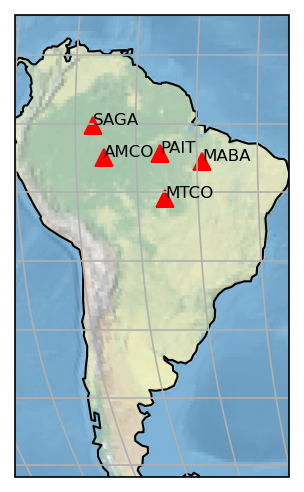

In [10]:
# Plot sur une cartes des stations GNSS étudiées
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.Robinson()}, dpi=150)

# Tracer les points sur la carte avec les codes en label
for code, (lat, lon) in stations.items():
    ax.plot(lon, lat, '^', markersize=8, color='red', transform=ccrs.Geodetic())
    ax.text(lon, lat, code, transform=ccrs.Geodetic(), fontsize=8, color='black')

# Ajouter les caractéristiques de la carte
# ax.set_global()
ax.set_extent([-80, -40, -50, 15])
ax.stock_img()
ax.coastlines()
ax.gridlines()

plt.savefig("../figures/stations_locations.png", dpi=200.)
plt.show()

## B. GRACE data

# A.1. Description des données

Le programme GRACE (Gravity Recovery And Climate Experiment) est un programme spatial de mesure du champ de gravité terrestre. Le principe est de mesurer finement la variation dans le temps de la séparation (range) entre deux satellites se suivant sur la même orbite. Des variations spatiales du champ de pesanteur entraînant des variations dans le temps de ce range.

Il désigne deux missions similaires, la première ayant eut lieu de 2002 jusqu'à 2018 et la seconde (GRACE Follow-On) étant en cours, commencée en 2018.

Ce programme est porté par plusieurs agences, tant dans le développement des satellites que dans le traitement et la mise à disposition des données produites.

L'appareil de mesure principal repose sur deux antennes micro-ondes, la variation du déphasage entre les signaux émis et reçu permet de retrouver l'évolution dans le temps du range entre les deux satellites. D'autres appareils sont également présents à bord : un accéleromètre (permettant de modéliser les forces non gravitationelles auxquelles les satellites peuvent être soumis), une caméra servant de capteur d'étoile pour connaître l'orientation des satellites dans un repère fixe, un GPS pour connaître l'heure à bord des satellites et leur position.

Les données sont fournies selon différents niveaux de traitements : 
- 1A : les données brutes (datées et calibrées) des différents appareils
- 1B : les données nettoyées et traitées (ex de produits : range et ses dérivées temporelles premières et secondes)
- 2 : estimations mensuelles du champ de gravité

Les données que nous utilisons ici sont des données de niveau 2. Le document [Level-2 Gravity Field Product User Handbook](https://deotb6e7tfubr.cloudfront.net/s3-edaf5da92e0ce48fb61175c28b67e95d/podaac-ops-cumulus-docs.s3.us-west-2.amazonaws.com/grace/open/docs/L2-UserHandbook_v4.0.pdf?A-userid=None&Expires=1705442146&Signature=D5r13RNRe2K7kD41UipU2D3H3iorLHsNGGlf3X9J0Net9lZNHZMgbMjAXj61-HX6mxplcg7Ti80bWRm2hhVj85uKJfh9n04r0OBkLrL6aWefiY2uiskhYwGib~Omxxw~uHY1A8nXvwDOFPJaPenbUO061zxoV~wJ2rAGEY69Fxr32mYBh4Vpje6~FuKJQ3SpsucqPcWqgVkQyhsxMgHeXVGZ3RPXkHM781Kq0Ncg-iSjp7hovK9tAiNIJkFjdHdnSDHaNU~P1FHhnZZDPxF4YxctMMZK91KDjo3nZ0T4rfosDa9Qg8DFVGOH8vTor0vwjHiMASvNAG1k9BBGKVJNZw__&Key-Pair-Id=K3OEOUZXFQBEJ5) défini la nature de ces données.

Il s'agit des coefficients de décomposition en harmonique sphérique (fully normalized) du potentiel gravitationnel de la Terre. Donné dans un repère dont l'origine est le centre de masse de la Terre (Terre solide et enveloppes fluides) : $\bar{C_{lm}}$ et $\bar{S_{lm}}$ de la décomposition suivante : 

$$
V(r,\phi,\lambda,t) = \mu/r + \mu/r\sum_{l=2}^{N_{max}}\left(\frac{a}{r}\right)^l\sum_{m=0}^l\bar{P_{lm}}(sin(\phi))\left[\bar{C_{lm}}cos(m\lambda)+\bar{S_{lm}}sin(m\lambda)\right]
$$

Le nom de ces fichiers est formatté et nous donne les dates de début et de fin d'acquisitions ayant contribuée à cette estimation ainsi que des informations complémentaires : 
- `GSM` : données de géopotentiel (`G`), construites uniquement à partir de données GRACE (`S`)
- `UTCSR` : données traitées par le CSR à l'University of Texas
- `BA01` : `A` = décomposition en harmoniques sphériques 60x60

### B.2. Traitement des données

En partant donc des coefficients de la décomposition en HS du champ de potentiel on réalise la chaîne de traitement suivant : 
1. On retire à une décomposition prise au temps $t$ la décomposition à un temps de référence au temps $t_0$ pour se ramener à l'anomalie entre le temps $t$ et $t_0$
2. On applique à la décomposition un filtre de décorrelation du signal, corrigeant en partie des artefacts observés : les stripes (bruit de mesure, renforcé et corrélé par la géometrie d'acquisition de GRACE). Ici on utilise le filtre DDK5 (voir Kusche et al. 2009).
3. A partir d'une donnée de nombres de Love de pesanteur associés à un modèle de Terre, on passe de l'anomalie de champ de potentiel $V_{lm}$ à la charge associée $\sigma_{lm}$ :

$$
h_{lm} = \frac{\rho_ea_e(2l+1)}{3\rho_w} \frac{1}{1+k_l} V_{lm}
$$

On peut ensuite, grâce aux nombres de Love $h_l$, on obtient finalement le déplacement de la surface de la Terre engendré par cette charge. Ex pour le déplacement vertical :
$$
U_{lm} = a_e \frac{h_l}{1+k_l} V_{lm}
$$

$a_e$ le rayon moyen de la Terre, $\rho_e$ sa densité moyenne, $\rho_w$ la densité de l'eau.
1. Enfin on se ramène à un champ en latitude/longitude.

**Implémentation :** on lit l'ensemble des fichiers de données GRACE, on récupère les dates contenues dans les titres. On associe à chaque fichier de donnée (chaque champ de potentiel) la date du milieu de l'acquisition. On prend comme référence la première mesure et on pour chaque fichier (chaque champ de potentiel) on applique la chaîne de traitement définie ci-dessus. On calcule les déformations enregistrées au cours du temps au coordonnées des stations GNSS chargées précedemment.

In [11]:
# Recherche des fichiers des données et extraction de la date à partir du nom

pattern = re.compile(r'(\d{4})(\d{3})-(\d{4})(\d{3})')

table_corres = {}

liste_files = os.listdir("../GRACE_data/")
liste_files.sort()

for fichier in liste_files:
    
    # Appliquer la regex sur le nom de fichier
    match = pattern.search(fichier)
    
    if match:
        # Extraire les parties YYYY et DDD
        annee1, jour_de_l_annee1, annee2, jour_de_l_annee2 = match.groups()
            
        # Convertir en date pour les deux champs
        date1_str = f"{annee1}-{jour_de_l_annee1}"
        date1 = datetime.strptime(date1_str, "%Y-%j").date()
        
        date2_str = f"{annee2}-{jour_de_l_annee2}"
        date2 = datetime.strptime(date2_str, "%Y-%j").date()
        
        table_corres[date1 + (date1-date2)/2] = fichier

Ici on montre un exemple de la chaîne de traitement appliquée à un unique snapshot d'anomalie de champ de potentiel. On plot à la fin le champ de la surcharge associée à l'anomalie de champ de pesanteur (exprimée en hauteur d'eau équivalente).

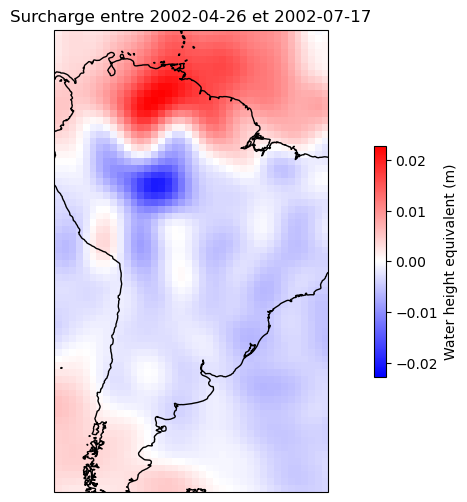

In [12]:
# 1. Calcul anomalie

file_1,file_2 = list(table_corres.values())[1:3]
dt1,dt2 = list(table_corres.keys())[1:3]

Clm_0 = grace_tools.read_grace_file("../GRACE_data/"+file_1)
Clm_1 = grace_tools.read_grace_file("../GRACE_data/"+file_2)

# 2. Filtre DDK5

dClm = grace_tools.filter_DDK5(Clm_1-Clm_0)

# 3. Hauteur d'eau équivalente
dHlm = grace_tools.dClm_to_Hlm(dClm)

# 3. Décomposition HS déplacement

Ulm,N1lm,N2lm,Elm = grace_tools.dClm_to_UN1N2Elm(dClm)

# 4. Passage en grille lat lon

lon = np.arange(-179.5, 180, 1)
lat = np.arange(-89.5, 90, 1)

(lon, lat) = np.meshgrid(lon, lat)

# Les latitudes en radians
phi = np.pi/180*lat

# dE = Elm.expand(lon=lon, lat=lat)/np.cos(phi)
# dN = N1lm.expand(lon=lon, lat=lat)*np.tan(phi) + N2lm.expand(lon=lon, lat=lat)/np.cos(phi)
dU = Ulm.expand(lon=lon, lat=lat)

#dH = dHlm.expand(lon=lon, lat=lat)

fig,ax,cbar = grace_tools.plot_cartopy(lat, lon, dU)#dH[::-1,:])
cbar.set_label("Water height equivalent (m)")
ax.set_title(f"Surcharge entre {dt1} et {dt2}")
# fig.savefig("../figures/dh_map_example.png", dpi=100)
ax.set_extent([-80, -40, -50, 15])
plt.show()

In [13]:
# Pour chaque station GNSS : calcul du déplacement à chaque date par rapport à la première mesure des données
    
file_0 = list(table_corres.values())[0]
Clm_0 = grace_tools.read_grace_file("../GRACE_data/"+file_0)

lons,lats = [],[]
for lat,lon in stations.values():
    lons.append(lon)
    lats.append(lat)
(lons, lats) = (np.array(lons), np.array(lats))
phi = np.pi/180*lats

code_stations = stations.keys()
dates = table_corres.keys()

multi_index = pd.MultiIndex.from_product([code_stations, dates], names=['Station', 'Date'])

grace_df = pd.DataFrame(np.zeros((len(multi_index),3)), index=multi_index, columns=['up', 'north', 'east'])

for date in dates : 

    Clm = grace_tools.read_grace_file("../GRACE_data/"+table_corres[date])
    dClm = grace_tools.filter_DDK5(Clm-Clm_0)

    Ulm,N1lm,N2lm,Elm = grace_tools.dClm_to_UN1N2Elm(dClm)

    dE = Elm.expand(lon=lons, lat=lats)/np.cos(phi)
    dN = N1lm.expand(lon=lons, lat=lats)*np.tan(phi) + N2lm.expand(lon=lon, lat=lat)/np.cos(phi)
    dU = Ulm.expand(lon=lons, lat=lats)

    for i,code in enumerate(stations.keys()):
        
        grace_df.loc[(code,date),"up"] = dU[i]
        grace_df.loc[(code,date),"north"] = dN[i]
        grace_df.loc[(code,date),"east"] = dE[i]

In [14]:
# Chargement du fichier de discontinuités 

gnss_steps = pd.read_fwf("../GNSS_data/steps_gnss_stations.txt")
gnss_steps.columns = ["Station", "YYMMMDD", "Code", "Description"]

gnss_steps["Date"] = gnss_steps["YYMMMDD"].apply(lambda x: datetime.strptime(x, "%y%b%d"))

gnss_steps = gnss_steps[["Station", "Date", "Description"]].set_index("Station")


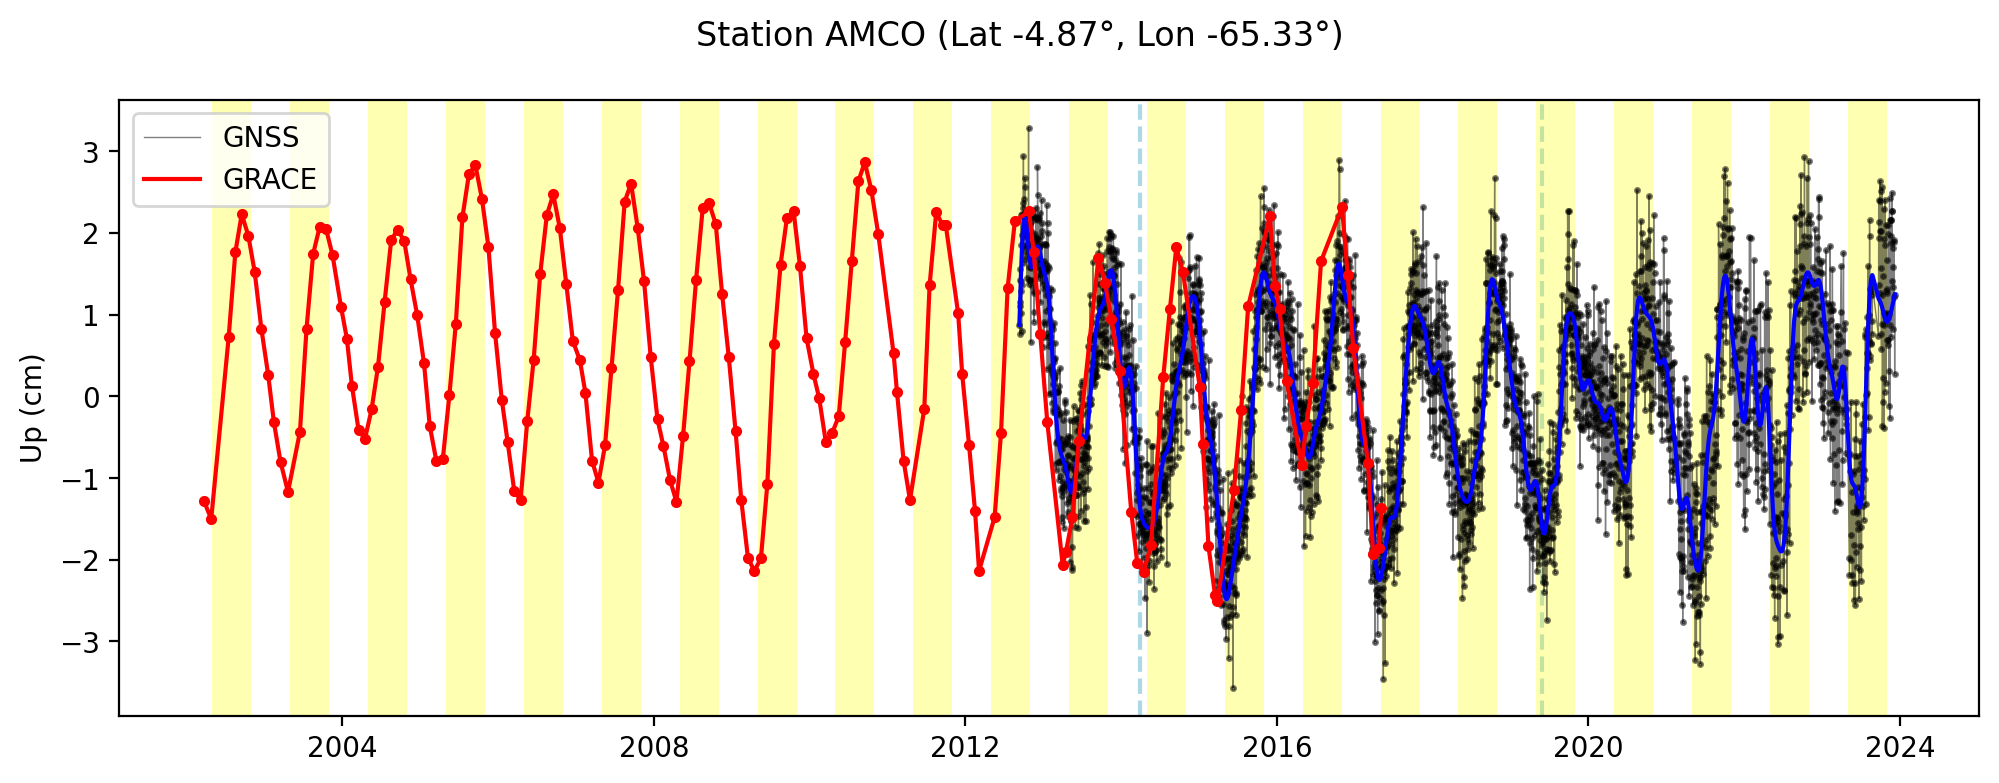

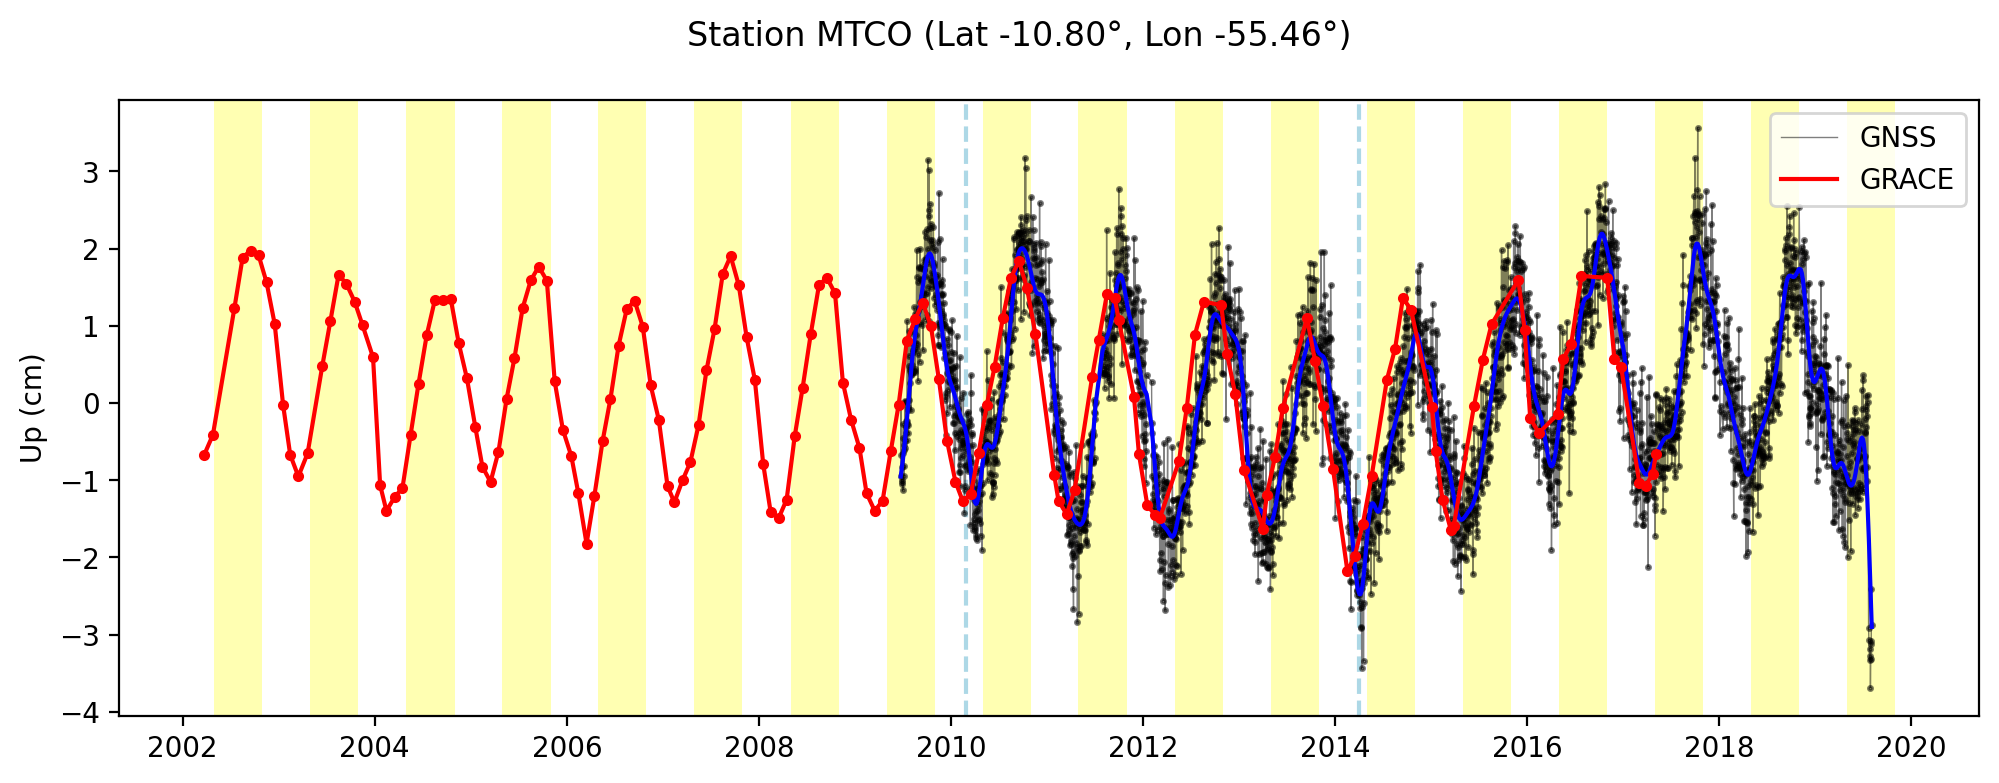

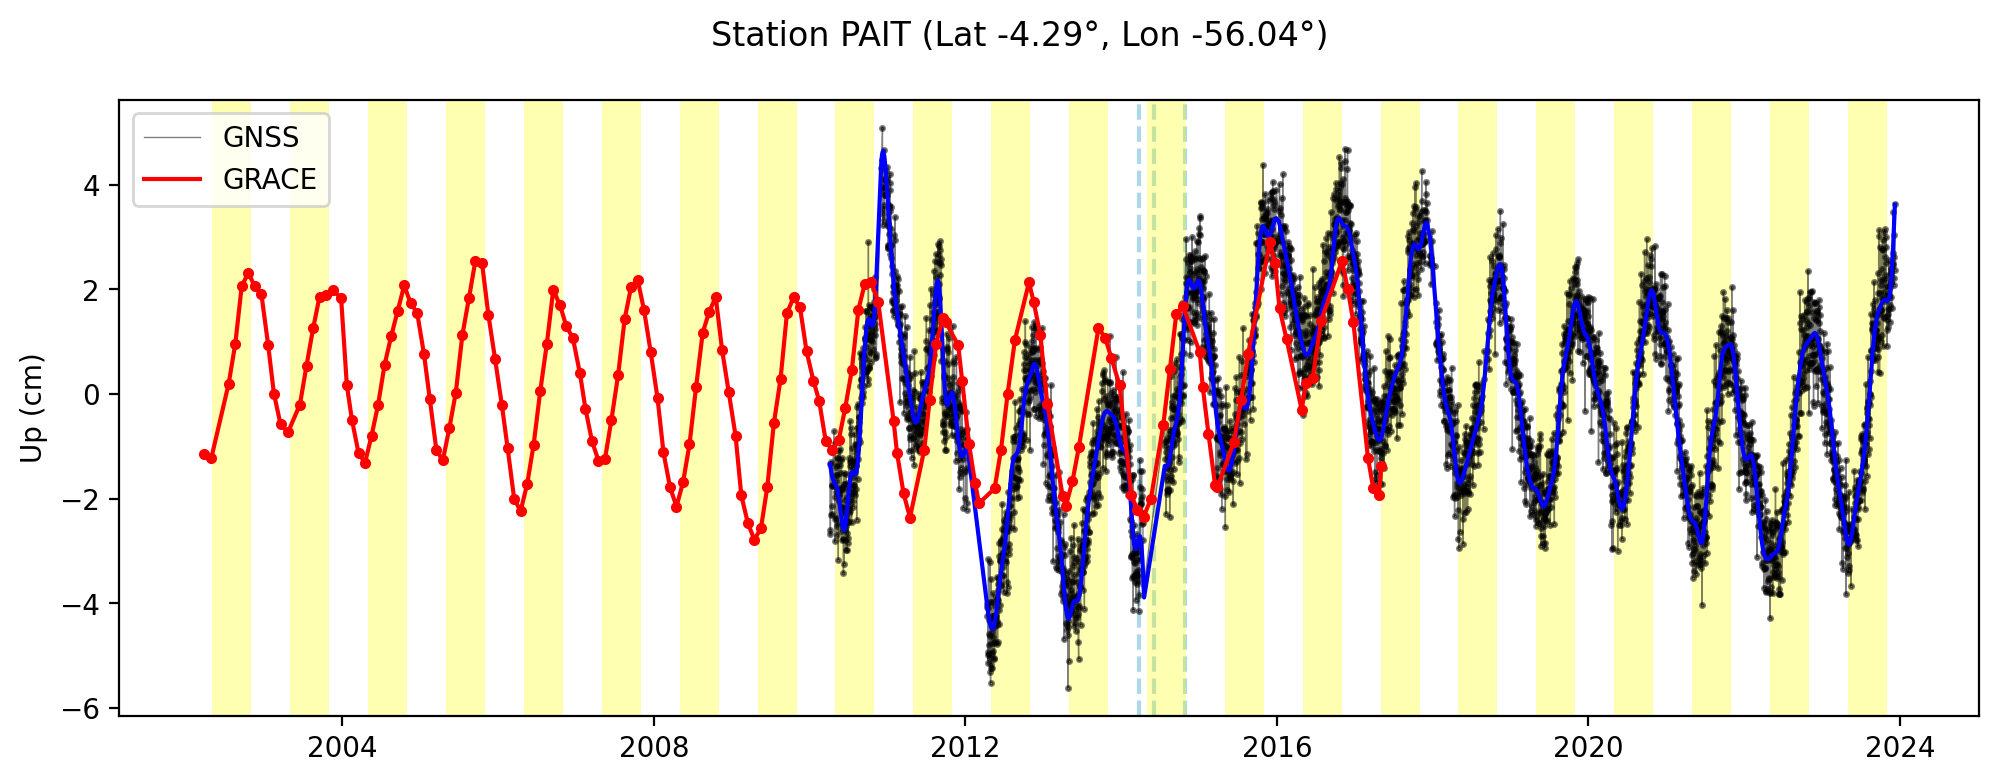

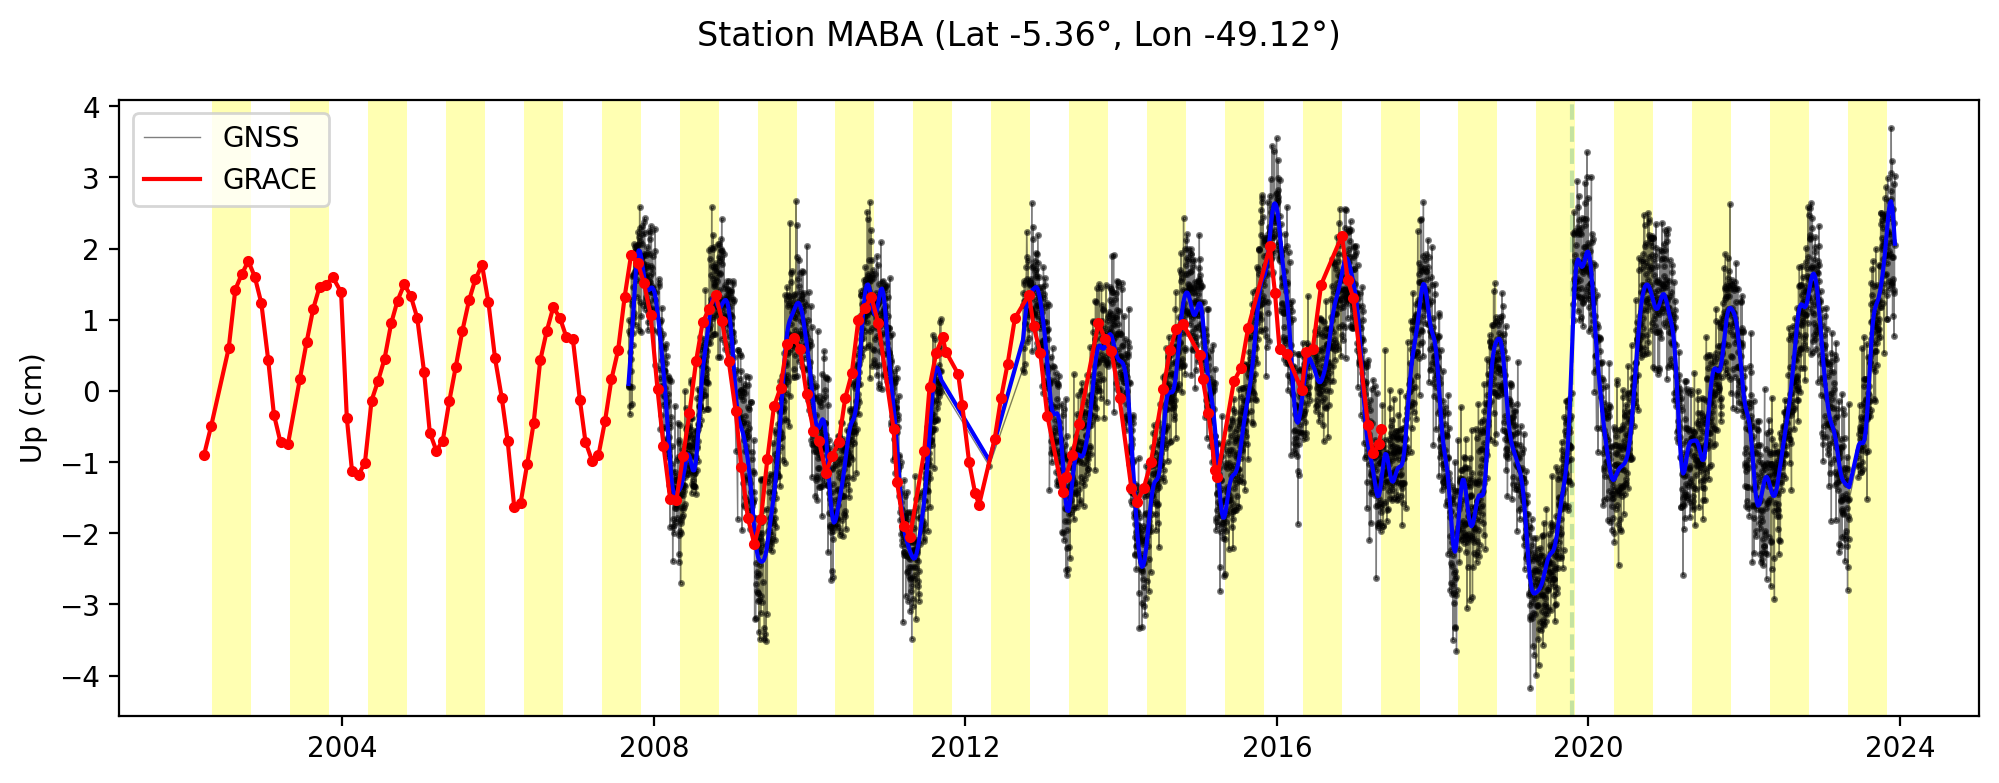

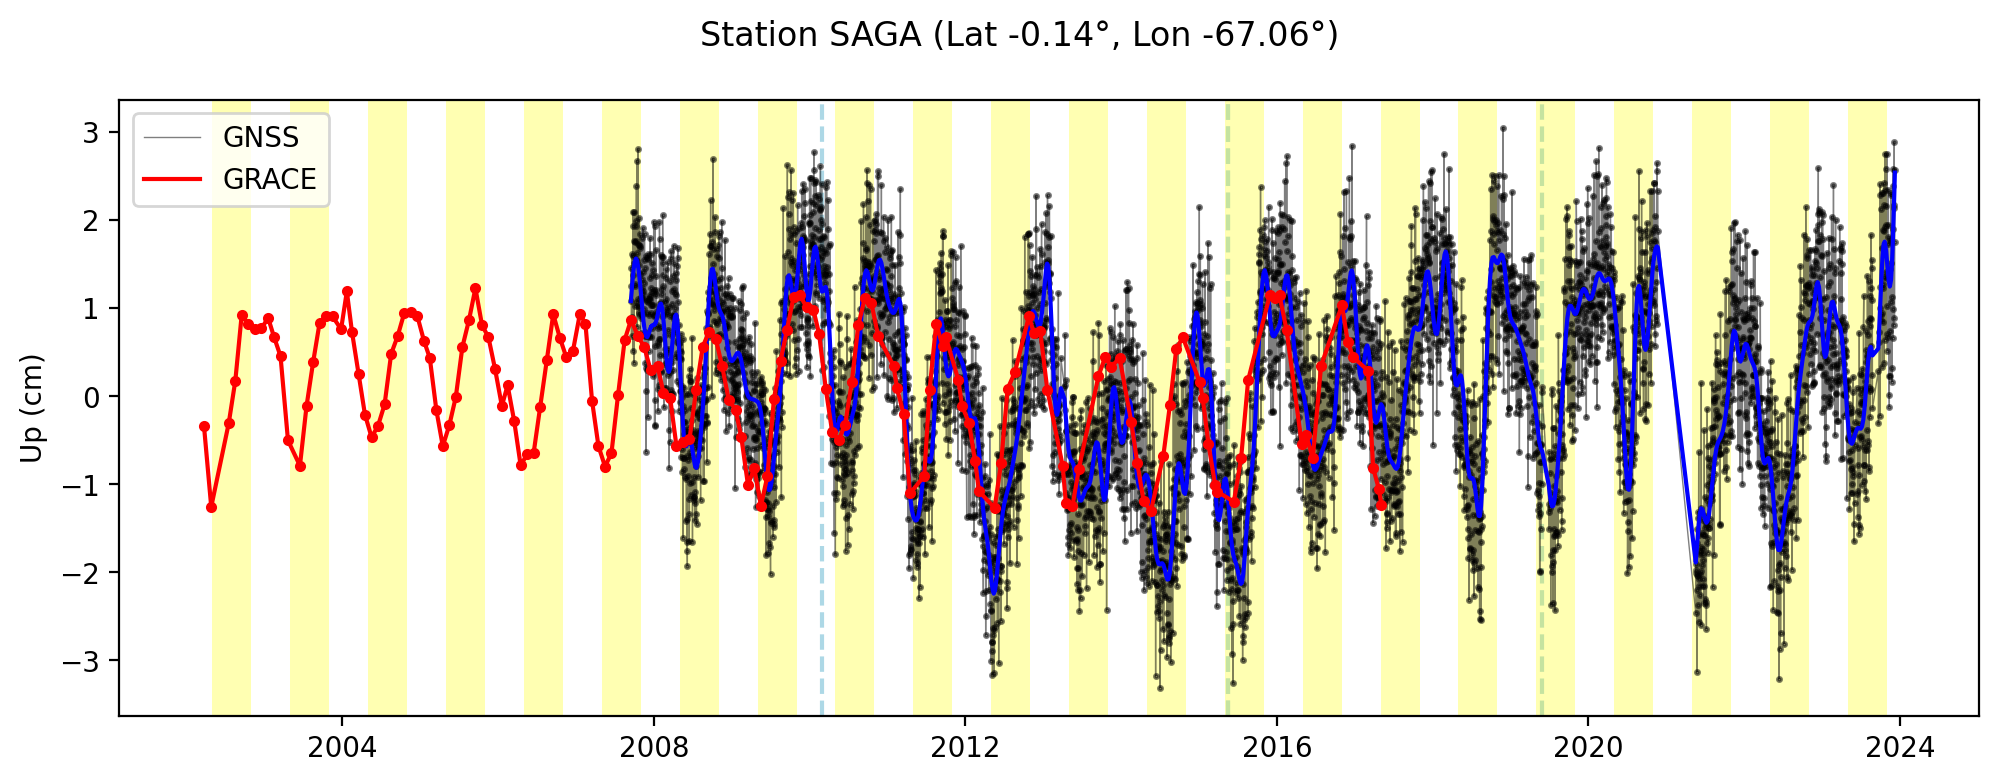

In [16]:
for station in stations.keys():
    
    grace_data = grace_df.loc[station]
    gnss_data = gnss_df.loc[station]
    gnss_steps_data = gnss_steps.loc[station]

    # Recaler les deux mesures : on retire leur moyenne sur la periode commune 
    dt1 = max(gnss_data.index[0].date(),grace_data.index[0])
    dt2 = min(gnss_data.index[-1].date(),grace_data.index[-1])
    i1_gnss, i1_grace = np.abs(gnss_data.index - pd.Timestamp(dt1)).argmin(),np.abs(grace_data.index - dt1).argmin()
    i2_gnss, i2_grace = np.abs(gnss_data.index - pd.Timestamp(dt2)).argmin(),np.abs(grace_data.index - dt2).argmin()
    grace_data -= grace_data.iloc[i1_grace:i2_grace].mean()
    gnss_data -= gnss_data.iloc[i1_gnss:i2_gnss].mean()
            
    # --- 1 composant ---
    cpnt = "up"
    fig, ax = plt.subplots(figsize=plt.figaspect(1/3), dpi=200.)

    ax.plot(gnss_data.index,gnss_data[cpnt+"_detrended"]*100 ,c="k",lw=0.5,alpha=0.5,label="GNSS")
    ax.plot(gnss_data.index,gnss_data[cpnt+"_detrended"]*100 ,c="k",alpha=0.5,marker=".",ls="",ms=3)
    ax.plot(gnss_data.index,gnss_data[cpnt+ "_dt_filtered"]*100 ,c="b")

    ax.plot(grace_data.index, grace_data[cpnt]*100, c="r",label=f"GRACE")
    ax.plot(grace_data.index, grace_data[cpnt]*100, ls="",marker=".",c="r")

    # Ajout des discontinuités renseignées pour la série GNSS
    if type(gnss_steps_data["Date"]) == pd.Timestamp:
        ax.axvline(gnss_steps_data["Date"], linestyle='--', color='lightblue', zorder=1)
    elif type(gnss_steps_data["Date"]) == pd.Series:
        for dt in gnss_steps_data["Date"]:
            ax.axvline(dt, linestyle='--', color='lightblue', zorder=1)
            
    # Ajout des alternances été hiver
    dtmin = min(gnss_data.index[0].date(),grace_data.index[0])
    dtmax = max(gnss_data.index[-1].date(),grace_data.index[-1])
    for year in range(dtmin.year, dtmax.year + 1):
        summer_start = pd.Timestamp(f"{year}-05-01")
        summer_end = pd.Timestamp(f"{year}-10-31")
        ax.axvspan(summer_start, summer_end, facecolor='yellow', alpha=0.3)

    ax.set_ylabel("Up (cm)")
    ax.legend()
        
    # ax.set_ylim(-0.03, 0.03)

    lat,lon = stations[station]
    fig.suptitle(f"Station {station} (Lat {lat:.2f}°, Lon {lon:.2f}°)")

    plt.savefig(f"../figures/{station}_{cpnt}.png", dpi=100.)

    plt.show()



# II. Observations 

On s'intéresse ici à montrer que les données GRACE perçoivent bien les variations annuelles du champ de gravité du aux oscillations hydrographiques du bassin amazonien.

Sur les graphes ci-dessus son représenté de manière comparative le déplacement vertical mesuré par les stations GNSS et le déplacement engendré par l'anomalie de champ de potentiel mesurée par GRACE. En bleu pointillé sont représentés les épisodes de possibles discontinuités de la série GNSS et en fond jaune la période d'été (1er Mai au 31 octobre).

Observations : 
- SAGA : signal periodique en phase.
- autres stations (MTCO) : léger déphasage (données GRACE en avance) ce qui montre les limites du modèle purement élastique.
- Un déphasage avec les données GPS peut être attribué aux propriétés visco-élastiques de l'asthénosphère. D'après [Chanard, 2018], un déphasage correspondant à ces charges de surface sur ces périodes temporelles peut être expliqué par une combinaison entre la valeur de viscosité transitoire $\eta_T$ (rhéologie de Burgers) et les valeurs des modèles de cisaillement transitoires $\mu_T$ et en régime permanant $\mu$.

Ref:
Chanard, K., Fleitout, L., Calais, E., Barbot, S. and Avouac, J.P., 2018. Constraints on transient viscoelastic rheology of the asthenosphere from seasonal deformation. Geophysical Research Letters, 45(5), pp.2328-2338.